# Optimal Delay-and-Subtract for 2-Mic Array (Implied Mic Spacing Calculation)

This notebook:
- Loads your 48kHz stereo WAV file (`input.wav`)
- Sweeps delay values to find the optimal one for suppressing the front direction
- Calculates the physical spacing between mics implied by this delay
- Outputs the processed result (`output_optimal.wav`)

*Left channel = front mic, Right channel = back mic*

In [1]:
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
fs = 16000
c = 343  # Speed of sound (m/s)

# Load audio
speaker = 'both'  # Change to 'josh' for the other file
input_file = f'{speaker}_in.wav'
# Read the file and resample to 16kHz if needed

audio, fs_loaded = librosa.load(input_file, sr=fs, mono=False)
audio = audio.T  # Transpose to shape (samples, channels)
# assert fs_loaded == fs, f"File must be 48kHz! (found {fs_loaded})"
assert audio.shape[1] == 2, "File must be stereo (front=left, back=right)"

front = audio[:, 1]
back = audio[:, 0]

print(f"Loaded '{input_file}' ({audio.shape[0]/fs:.2f} seconds).")

Loaded 'both_in.wav' (17.05 seconds).


In [2]:
# Fractional delay function (linear interpolation)
def fractional_delay(sig, delay):
    idx = np.arange(len(sig))
    idx_delayed = idx - delay
    idx0 = np.floor(idx_delayed).astype(int)
    idx1 = idx0 + 1
    w1 = idx_delayed - idx0
    valid = (idx0 >= 0) & (idx1 < len(sig))
    y = np.zeros_like(sig)
    y[valid] = (1 - w1[valid]) * sig[idx0[valid]] + w1[valid] * sig[idx1[valid]]
    return y

In [3]:
from scipy.signal import stft, istft


def simple_dereverb(audio, fs, frame_len=1024, frame_hop=256, alpha=1):
    """
    Simple dereverberation via spectral subtraction of a running minimum.
    alpha: How much of late energy to subtract (0=none, 1=aggressive).
    """
    # STFT
    f, t, Zxx = stft(audio, fs=fs, nperseg=frame_len, noverlap=frame_len-frame_hop)
    mag = np.abs(Zxx)
    phase = np.angle(Zxx)
    # Estimate late energy floor (minimum over trailing window)
    min_win = 10  # number of frames for min-energy floor (adjust as needed)
    mag_min = np.minimum.accumulate(mag, axis=1)
    mag_sub = np.maximum(mag - alpha * mag_min, 0)
    # Recombine and iSTFT
    Zxx_clean = mag_sub * np.exp(1j * phase)
    _, audio_clean = istft(Zxx_clean, fs=fs, nperseg=frame_len, noverlap=frame_len-frame_hop)
    # Truncate to original length
    return audio_clean[:len(audio)]

# front = simple_dereverb(front, fs)
# back = simple_dereverb(back, fs)

100%|██████████| 800/800 [00:08<00:00, 89.56it/s]


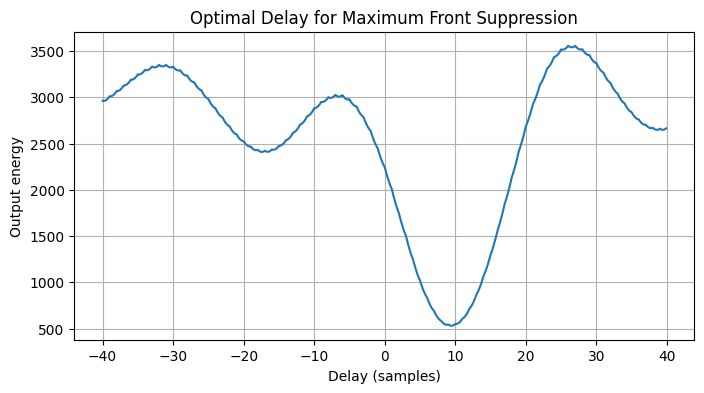

Optimal delay for suppression: 9.50 samples


In [4]:
# --- Delay Sweep for Optimal Front Suppression ---

min_delay = -40.0  # Minimum delay in samples
max_delay = 40.0
step = 0.1
delays = np.arange(min_delay, max_delay, step)
energies = []

# Focus on a region where only the front is active
region = slice(int(2*fs), int(3*fs))   # or region = slice(start, end) for a segment
# region = slice(None)  # Use the entire signal for now
for dly in tqdm(delays):
    back_delayed = fractional_delay(back, dly)
    output = front - back_delayed
    seg = output[region]
    energy = np.sum(seg ** 2)
    energies.append(energy)

energies = np.array(energies)

plt.figure(figsize=(8,4))
plt.plot(delays, energies)
plt.xlabel("Delay (samples)")
plt.ylabel("Output energy")
plt.title("Optimal Delay for Maximum Front Suppression")
plt.grid()
plt.show()

optimal_delay = delays[np.argmin(energies)]
print(f"Optimal delay for suppression: {optimal_delay:.2f} samples")

In [5]:
# Calculate implied mic spacing d
delay_sec = optimal_delay / fs
d_estimated = delay_sec * c
print(f"Implied microphone spacing: {d_estimated*100:.1f} cm")



Implied microphone spacing: 20.4 cm


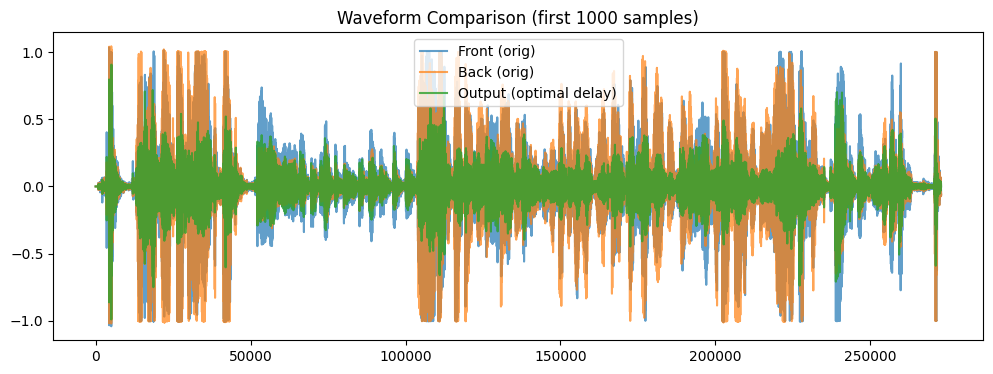

In [6]:
# Create and save processed audio with optimal delay
back_delayed_opt = fractional_delay(back, optimal_delay)

front_seg = front[region]
back_delayed_seg = back_delayed_opt[region]


output_opt = front - back_delayed_opt
# Normalize to prevent clipping
maxval = np.max(np.abs(output_opt))
if maxval > 0.99:
    output_opt = 0.99 * output_opt / maxval

sf.write(f"{speaker}_out.wav", output_opt, fs)

# Optional: compare waveforms visually
# region=slice(15*fs, 20 * fs)
region=slice(None)
plt.figure(figsize=(12,4))
plt.plot(front[region], label="Front (orig)", alpha=0.7)
plt.plot(back[region], label="Back (orig)", alpha=0.7)
plt.plot(output_opt[region], label="Output (optimal delay)", alpha=0.8)
plt.legend()
plt.title("Waveform Comparison")
plt.show()

In [7]:
# --- LMS Adaptive Filtering for Front Suppression ---  

def lms_filter(x, d, M=16, mu=0.1):
    # x: reference (front), d: desired (back)
    N = len(x)
    w = np.zeros(M)
    y = np.zeros(N)
    for n in range(M, N):
        x_vec = x[n-M:n][::-1]
        y[n] = np.dot(w, x_vec)
        e = d[n] - y[n]
        w = w + 2 * mu * e * x_vec
    return d - (y if speaker == 'josh' else -y)  # output: residual (back with front adaptively suppressed/added)

# Apply LMS filter for adaptive suppression
output_lms = lms_filter(back, front, M=128, mu=0.001)
# Normalize to prevent clipping
maxval = np.max(np.abs(output_lms))
if maxval > 0.99:
    output_lms = 0.99 * output_lms / maxval
sf.write(f"{speaker}_lms.wav", output_lms, fs)



In [8]:
sf.write(f"{speaker}_lms_dereverb.wav",  simple_dereverb(output_lms, fs), fs)

